In [76]:
import pandas as pd
import numpy as np


from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support


from sklearn.model_selection import GridSearchCV

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

import seaborn as sns
import itertools



In [10]:
df = pd.read_parquet("df_preprocessed_windows.parquet")

#split:
train_cycles = ["B1", "B2"]
val_cycles   = ["A1"]
test_cycles  = ["A2"]

df_train = df[df["cycle_id"].isin(train_cycles)].copy()
df_val   = df[df["cycle_id"].isin(val_cycles)].copy()
df_test  = df[df["cycle_id"].isin(test_cycles)].copy()

print("Train size:", df_train.shape)
print("Val size:", df_val.shape)
print("Test size:", df_test.shape)
print("Positive rates:",
      df_train["label"].mean(),
      df_val["label"].mean(),
      df_test["label"].mean())


Train size: (5448, 28)
Val size: (4524, 28)
Test size: (4077, 28)
Positive rates: 0.06167400881057269 0.03713527851458886 0.041206769683590876


In [97]:
# features

feature_cols_full = [
    c for c in df.columns
    if c not in ["pump_id", "cycle_id", "end_time", "label"]
]

feature_cols_reduced = [
    "delta_p_mean",
    "delta_p_std",
    "delta_p_trend",
    "output_mean",
    "output_std",
    "output_trend",
    "active_pressure_fraction",
]

FEATURE_SET = "reduced"      #  "full or "reduced"----=

if FEATURE_SET == "full":
    feature_cols = feature_cols_full
elif FEATURE_SET == "reduced":
    feature_cols = feature_cols_reduced

    

X_train = df_train[feature_cols]
y_train = df_train["label"]

X_val = df_val[feature_cols]
y_val = df_val["label"]

X_test = df_test[feature_cols]
y_test = df_test["label"]

#==========================use for all models!




In [90]:
lr_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100]
}


In [91]:
grid = GridSearchCV(
    estimator=lr_pipe,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC (primary metric)
    cv=[(np.arange(len(X_train)), np.arange(len(X_val)))],
    refit=True
)

# Fit: training data only
grid.fit(
    pd.concat([X_train, X_val]),
    pd.concat([y_train, y_val])
)

print("\nBest Logistic Regression parameters:")
print(grid.best_params_)

best_model = grid.best_estimator_



Best Logistic Regression parameters:
{'clf__C': 100}


In [92]:
y_val_pred  = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

print("\n=== VALIDATION RESULTS ===")
print(classification_report(y_val, y_val_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("PR-AUC :", average_precision_score(y_val, y_val_proba))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))



=== VALIDATION RESULTS ===
              precision    recall  f1-score   support

           0      1.000     0.913     0.955      4356
           1      0.308     1.000     0.471       168

    accuracy                          0.917      4524
   macro avg      0.654     0.957     0.713      4524
weighted avg      0.974     0.917     0.937      4524

ROC-AUC: 0.9804128951856226
PR-AUC : 0.6143410485517381
Confusion matrix:
 [[3979  377]
 [   0  168]]


In [93]:
y_test_pred  = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== TEST RESULTS ===")
print(classification_report(y_test, y_test_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("PR-AUC :", average_precision_score(y_test, y_test_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))


=== TEST RESULTS ===
              precision    recall  f1-score   support

           0      1.000     0.646     0.785      3909
           1      0.108     1.000     0.196       168

    accuracy                          0.661      4077
   macro avg      0.554     0.823     0.490      4077
weighted avg      0.963     0.661     0.761      4077

ROC-AUC: 0.9192735932950822
PR-AUC : 0.1974902728133412
Confusion matrix:
 [[2527 1382]
 [   0  168]]


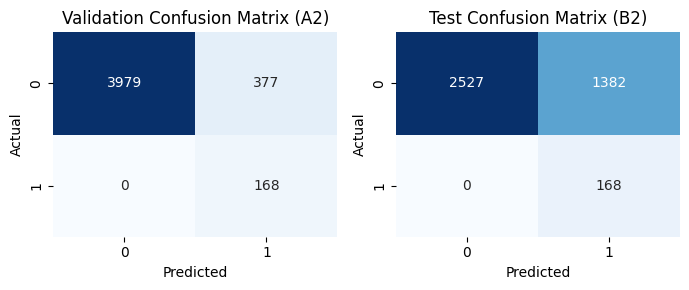

In [94]:

cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(7, 3))

sns.heatmap(
    cm_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[0],
    cbar=False
)
axes[0].set_title("Validation Confusion Matrix (A2)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(
    cm_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[1],
    cbar=False
)
axes[1].set_title("Test Confusion Matrix (B2)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [96]:

perm = permutation_importance(
    lr_pipe,
    X_val,
    y_val,
    scoring="f1",
    n_repeats=30,
    random_state=42
)

perm_df = pd.DataFrame({
    "feature": feature_cols_reduced,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=perm_df,
    x="importance_mean",
    y="feature",
    color="steelblue"
)
plt.xlabel("Mean decrease in F1-score", fontsize=11)
plt.ylabel("")
plt.title("Permutation Importance (Reduced Feature Set, Validation A2)", fontsize=12)
plt.tight_layout()
plt.show()


AttributeError: 'LogisticRegression' object has no attribute 'classes_'

In [43]:

#=============================Random forest
#=============================

def rf_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),   # includes default 100
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": "balanced_subsample",
        "random_state": 42,
        "n_jobs": -1
    }

    rf = RandomForestClassifier(**params)
    rf.fit(X_train, y_train)

    val_proba = rf.predict_proba(X_val)[:, 1]
    pr_auc = average_precision_score(y_val, val_proba)

    return pr_auc

study = optuna.create_study(direction="maximize")
study.optimize(rf_objective, n_trials=50)

best_params = study.best_params
print("Best RF parameters:", best_params)


[I 2026-01-07 20:41:33,173] A new study created in memory with name: no-name-6ea6b950-41fc-4b1d-aed3-061b62794e3e
[I 2026-01-07 20:41:33,750] Trial 0 finished with value: 0.11329058863524193 and parameters: {'n_estimators': 310, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.11329058863524193.
[I 2026-01-07 20:41:34,037] Trial 1 finished with value: 0.11291512684321847 and parameters: {'n_estimators': 157, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.11329058863524193.
[I 2026-01-07 20:41:34,910] Trial 2 finished with value: 0.12787111425902478 and parameters: {'n_estimators': 499, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.12787111425902478.
[I 2026-01-07 20:41:35,437] Trial 3 finished with value: 0.14617147289510618 and parameters: {'n_estimators': 299, 'max_depth': 1

Best RF parameters: {'n_estimators': 106, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}


In [44]:
rf_final = RandomForestClassifier(
    **best_params,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=9, n_estimators=106, n_jobs=-1,
                       random_state=42)

In [46]:
# Validation
val_pred = rf_final.predict(X_val)
val_proba = rf_final.predict_proba(X_val)[:, 1]

print("\n=== RANDOM FOREST — VALIDATION ===")
print(classification_report(y_val, val_pred))
print("ROC-AUC:", roc_auc_score(y_val, val_proba))
print("PR-AUC :", average_precision_score(y_val, val_proba))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))

# Test
test_pred = rf_final.predict(X_test)
test_proba = rf_final.predict_proba(X_test)[:, 1]

print("\n=== RANDOM FOREST — TEST ===")
print(classification_report(y_test, test_pred))
print("ROC-AUC:", roc_auc_score(y_test, test_proba))
print("PR-AUC :", average_precision_score(y_test, test_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))



=== RANDOM FOREST — VALIDATION ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4356
           1       0.00      0.00      0.00       168

    accuracy                           0.95      4524
   macro avg       0.48      0.49      0.49      4524
weighted avg       0.93      0.95      0.94      4524

ROC-AUC: 0.7897850255804802
PR-AUC : 0.17069032621928967
Confusion matrix:
 [[4294   62]
 [ 168    0]]

=== RANDOM FOREST — TEST ===
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3909
           1       0.00      0.00      0.00       168

    accuracy                           0.90      4077
   macro avg       0.48      0.47      0.47      4077
weighted avg       0.92      0.90      0.91      4077

ROC-AUC: 0.5328682892957644
PR-AUC : 0.0806334487712269
Confusion matrix:
 [[3673  236]
 [ 168    0]]


In [65]:

#=====================
#=====================XGBoost



def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),   # default = 100
        "max_depth": trial.suggest_int("max_depth", 2, 10),            # default = 6
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  # default = 0.3
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),       # default = 1.0
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0), # default = 1.0
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10), # default = 1
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "random_state": 42,
        "n_jobs": -1,
    }

    model = XGBClassifier(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
        early_stopping_rounds=20
    )

    y_val_proba = model.predict_proba(X_val)[:, 1]
    pr_auc = average_precision_score(y_val, y_val_proba)

    return pr_auc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best XGBoost parameters:")
print(study.best_params)
print("Best validation PR-AUC:", study.best_value)



[I 2026-01-08 12:49:21,755] A new study created in memory with name: no-name-d01d7d82-0453-42a7-b6f1-0ea1226af29e
/Users/teunlangenhuijsen/thesis_env/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2026-01-08 12:49:21,810] Trial 0 finished with value: 0.06169078962929346 and parameters: {'n_estimators': 394, 'max_depth': 4, 'learning_rate': 0.04107441222797902, 'subsample': 0.6554754122056621, 'colsample_bytree': 0.9682779575975535, 'min_child_weight': 10}. Best is trial 0 with value: 0.06169078962929346.
/Users/teunlangenhuijsen/thesis_env/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2

Best XGBoost parameters:
{'n_estimators': 466, 'max_depth': 5, 'learning_rate': 0.049800048076586716, 'subsample': 0.9722756686285132, 'colsample_bytree': 0.6225521602943023, 'min_child_weight': 4}
Best validation PR-AUC: 0.11998040148071287


In [66]:
best_params = study.best_params

xgb_final = XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

xgb_final.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False,
    early_stopping_rounds=20
)


/Users/teunlangenhuijsen/thesis_env/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6225521602943023, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.049800048076586716,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=466, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [67]:

#val
y_val_pred  = xgb_final.predict(X_val)
y_val_proba = xgb_final.predict_proba(X_val)[:, 1]

print("\n=== XGBOOST — VALIDATION ===")
print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("PR-AUC :", average_precision_score(y_val, y_val_proba))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))


# 
y_test_pred  = xgb_final.predict(X_test)
y_test_proba = xgb_final.predict_proba(X_test)[:, 1]

print("\n=== XGBOOST — TEST ===")
print(classification_report(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("PR-AUC :", average_precision_score(y_test, y_test_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))



=== XGBOOST — VALIDATION ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4356
           1       0.00      0.00      0.00       168

    accuracy                           0.95      4524
   macro avg       0.48      0.49      0.49      4524
weighted avg       0.93      0.95      0.94      4524

ROC-AUC: 0.6878846637369365
PR-AUC : 0.11998040148071287
Confusion matrix:
 [[4294   62]
 [ 168    0]]

=== XGBOOST — TEST ===
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3909
           1       0.00      0.00      0.00       168

    accuracy                           0.90      4077
   macro avg       0.48      0.47      0.47      4077
weighted avg       0.92      0.90      0.91      4077

ROC-AUC: 0.38597132380708743
PR-AUC : 0.061307420748128824
Confusion matrix:
 [[3680  229]
 [ 168    0]]


In [85]:

# =================
# =================OneClass-SVM

# train
X_train_h = X_train[y_train == 0].copy()

scaler = StandardScaler()
X_train_h_scaled = scaler.fit_transform(X_train_h)
X_val_scaled     = scaler.transform(X_val)
X_test_scaled    = scaler.transform(X_test)

# hyperparameters
param_grid = {
    "kernel": ["rbf", "poly"],
    "nu": [0.01, 0.05, 0.10, 0.20, 0.50],
    "gamma": ["scale", "auto"]
}

best_pr_auc = -np.inf
best_params = None

for kernel, nu, gamma in itertools.product(
    param_grid["kernel"],
    param_grid["nu"],
    param_grid["gamma"]
):
    model = OneClassSVM(kernel=kernel, nu=nu, gamma=gamma)
    model.fit(X_train_h_scaled)

    val_scores = -model.decision_function(X_val_scaled)
    pr_auc = average_precision_score(y_val, val_scores)

    if pr_auc > best_pr_auc:
        best_pr_auc = pr_auc
        best_params = {
            "kernel": kernel,
            "nu": nu,
            "gamma": gamma
        }

print("\nBest OC-SVM hyperparameters:")
print(best_params)
print("Best validation PR-AUC:", best_pr_auc)

# fit
best_ocsvm = OneClassSVM(**best_params)
best_ocsvm.fit(X_train_h_scaled)

val_scores  = -best_ocsvm.decision_function(X_val_scaled)
test_scores = -best_ocsvm.decision_function(X_test_scaled)

# auc (no treshold
print("\n=== AUC ===")
print("VAL  ROC-AUC:", roc_auc_score(y_val, val_scores))
print("VAL  PR-AUC :", average_precision_score(y_val, val_scores))
print("TEST ROC-AUC:", roc_auc_score(y_test, test_scores))
print("TEST PR-AUC :", average_precision_score(y_test, test_scores))

# treshold selection
thresholds = np.linspace(
    np.percentile(val_scores, 1),
    np.percentile(val_scores, 99),
    200
)

best_f1 = -1
best_threshold = None

for t in thresholds:
    val_pred = (val_scores >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(
        y_val, val_pred, average="binary", zero_division=0
    )
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("\nSelected threshold (validation):", best_threshold)
print("Best validation F1:", best_f1)

# performance
val_pred  = (val_scores  >= best_threshold).astype(int)
test_pred = (test_scores >= best_threshold).astype(int)

print("\n=== THRESHOLDED PERFORMANCE ===")
print("Validation:")
print(precision_recall_fscore_support(
    y_val, val_pred, average="binary", zero_division=0
))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))

print("\nTest:")
print(precision_recall_fscore_support(
    y_test, test_pred, average="binary", zero_division=0
))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))



Best OC-SVM hyperparameters:
{'kernel': 'poly', 'nu': 0.01, 'gamma': 'scale'}
Best validation PR-AUC: 0.07121150697579051

=== AUC ===
VAL  ROC-AUC: 0.7671848353666536
VAL  PR-AUC : 0.07121150697579051
TEST ROC-AUC: 0.9143079462534567
TEST PR-AUC : 0.18463739171405164

Selected threshold (validation): 0.1786079539967118
Best validation F1: 0.15112540192926044

=== THRESHOLDED PERFORMANCE ===
Validation:
(0.08303886925795052, 0.8392857142857143, 0.15112540192926044, None)
Confusion matrix:
 [[2799 1557]
 [  27  141]]

Test:
(0.1320754716981132, 1.0, 0.23333333333333334, None)
Confusion matrix:
 [[2805 1104]
 [   0  168]]


In [88]:

# =================
# =================isolation forest

import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_fscore_support,
    confusion_matrix
)

# train
X_train_normal = X_train[y_train == 0]

# hyperparameter
param_grid = {
    "n_estimators": [100, 200, 400],
    "max_samples": [0.6, 0.8, 1.0],
    "contamination": [0.01, 0.02, 0.05, 0.10],
}

best_pr_auc = -1
best_params = None
best_model = None

for n_estimators in param_grid["n_estimators"]:
    for max_samples in param_grid["max_samples"]:
        for contamination in param_grid["contamination"]:
            model = IsolationForest(
                n_estimators=n_estimators,
                max_samples=max_samples,
                contamination=contamination,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train_normal)

            val_scores = -model.decision_function(X_val)
            pr_auc = average_precision_score(y_val, val_scores)

            if pr_auc > best_pr_auc:
                best_pr_auc = pr_auc
                best_params = {
                    "n_estimators": n_estimators,
                    "max_samples": max_samples,
                    "contamination": contamination
                }
                best_model = model

print("\nBest Isolation Forest hyperparameters:")
print(best_params)
print("Best validation PR-AUC:", best_pr_auc)

# anomaly scores
val_scores  = -best_model.decision_function(X_val)
test_scores = -best_model.decision_function(X_test)

print("\n=== AUC ===")
print("VAL  ROC-AUC:", roc_auc_score(y_val, val_scores))
print("VAL  PR-AUC :", average_precision_score(y_val, val_scores))
print("TEST ROC-AUC:", roc_auc_score(y_test, test_scores))
print("TEST PR-AUC :", average_precision_score(y_test, test_scores))

# treshold selection
thresholds = np.percentile(val_scores, np.linspace(50, 99.9, 300))

best_f1 = -1
best_threshold = None

for t in thresholds:
    val_pred = (val_scores >= t).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(
        y_val, val_pred, average="binary", zero_division=0
    )
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("\nSelected threshold (validation):", best_threshold)
print("Best validation F1:", best_f1)

# performance
val_pred  = (val_scores  >= best_threshold).astype(int)
test_pred = (test_scores >= best_threshold).astype(int)

print("\n=== THRESHOLDED PERFORMANCE ===")

print("\nValidation:")
print(precision_recall_fscore_support(
    y_val, val_pred, average="binary", zero_division=0
))
print("Confusion matrix:\n", confusion_matrix(y_val, val_pred))

print("\nTest:")
print(precision_recall_fscore_support(
    y_test, test_pred, average="binary", zero_division=0
))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))



Best Isolation Forest hyperparameters:
{'n_estimators': 100, 'max_samples': 0.8, 'contamination': 0.01}
Best validation PR-AUC: 0.03711726885557601

=== AUC ===
VAL  ROC-AUC: 0.5467240041103677
VAL  PR-AUC : 0.03711726885557601
TEST ROC-AUC: 0.6998935606475898
TEST PR-AUC : 0.06121854802336039

Selected threshold (validation): -0.07978712476539365
Best validation F1: 0.0829805249788315

=== THRESHOLDED PERFORMANCE ===

Validation:
(0.044667274384685506, 0.5833333333333334, 0.0829805249788315, None)
Confusion matrix:
 [[2260 2096]
 [  70   98]]

Test:
(0.04566458276705627, 1.0, 0.08734078502729399, None)
Confusion matrix:
 [[ 398 3511]
 [   0  168]]
